In [1]:
import healpy as hp
import pandas as pd
import numpy as np
import rubin_sim.maf_proto as maf
import sqlite3
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
# database file from:  https://s3df.slac.stanford.edu/data/rubin/sim-data/sv/sv_progress_databases/lsstcam_20250930/lsstcam_20250930.db
con = sqlite3.connect("lsstcam_20250930.db")
df = pd.read_sql("select * from observations;", con)
con.close()
visits_array = df.to_records(index=False)

In [8]:
sl = maf.Slicer(nside=128)
metric = maf.CountMetric()
hp_array = sl(visits_array, metric)


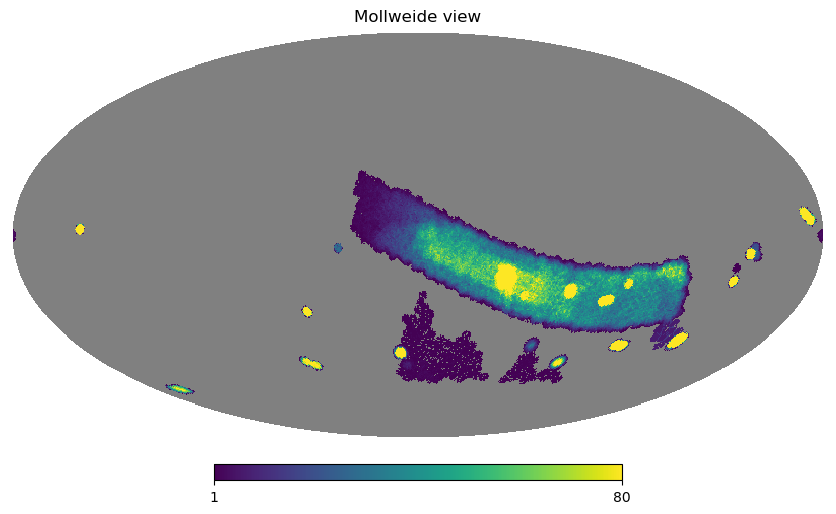

In [9]:
hp.mollview(hp_array, max=80)

In [10]:
hp.fitsfunc.write_map("lsstcam_20250930_nvisits.fits", hp_array)

setting the output map dtype to [dtype('float64')]
